<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#基于Cora数据集的GCN节点分类" data-toc-modified-id="基于Cora数据集的GCN节点分类-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>基于Cora数据集的GCN节点分类</a></span><ul class="toc-item"><li><span><a href="#SetUp" data-toc-modified-id="SetUp-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>SetUp</a></span></li><li><span><a href="#数据准备" data-toc-modified-id="数据准备-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>数据准备</a></span></li><li><span><a href="#图卷积层定义" data-toc-modified-id="图卷积层定义-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>图卷积层定义</a></span></li><li><span><a href="#模型定义" data-toc-modified-id="模型定义-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>模型定义</a></span></li><li><span><a href="#模型训练" data-toc-modified-id="模型训练-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>模型训练</a></span></li></ul></li></ul></div>

# 基于Cora数据集的GCN节点分类

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/FighterLYL/GraphNeuralNetwork/blob/master/chapter5/GCN_Cora.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

在Colab中运行时可以通过`代码执行程序->更改运行时类型`选择使用`GPU`

## SetUp

In [5]:
import itertools
import os
import os.path as osp
import pickle
import urllib
from collections import namedtuple

import numpy as np
import scipy.sparse as sp
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline

## 数据准备

In [6]:
Data = namedtuple('Data', ['x', 'y', 'adjacency',
                           'train_mask', 'val_mask', 'test_mask'])


def tensor_from_numpy(x, device):
    return torch.from_numpy(x).to(device)


class CoraData(object):
    download_url = "https://raw.githubusercontent.com/kimiyoung/planetoid/master/data"
    filenames = ["ind.cora.{}".format(name) for name in
                 ['x', 'tx', 'allx', 'y', 'ty', 'ally', 'graph', 'test.index']]

    def __init__(self, data_root="cora", rebuild=False):
        """Cora数据，包括数据下载，处理，加载等功能
        当数据的缓存文件存在时，将使用缓存文件，否则将下载、进行处理，并缓存到磁盘

        处理之后的数据可以通过属性 .data 获得，它将返回一个数据对象，包括如下几部分：
            * x: 节点的特征，维度为 2708 * 1433，类型为 np.ndarray
            * y: 节点的标签，总共包括7个类别，类型为 np.ndarray
            * adjacency: 邻接矩阵，维度为 2708 * 2708，类型为 scipy.sparse.coo.coo_matrix
            * train_mask: 训练集掩码向量，维度为 2708，当节点属于训练集时，相应位置为True，否则False
            * val_mask: 验证集掩码向量，维度为 2708，当节点属于验证集时，相应位置为True，否则False
            * test_mask: 测试集掩码向量，维度为 2708，当节点属于测试集时，相应位置为True，否则False

        Args:
        -------
            data_root: string, optional
                存放数据的目录，原始数据路径: {data_root}/raw
                缓存数据路径: {data_root}/processed_cora.pkl
            rebuild: boolean, optional
                是否需要重新构建数据集，当设为True时，如果存在缓存数据也会重建数据

        """
        self.data_root = data_root
        save_file = osp.join(self.data_root, "processed_cora.pkl")
        if osp.exists(save_file) and not rebuild:
            print("Using Cached file: {}".format(save_file))
            self._data = pickle.load(open(save_file, "rb"))
        else:
            self.maybe_download()
            self._data = self.process_data()
            with open(save_file, "wb") as f:
                pickle.dump(self.data, f)
            print("Cached file: {}".format(save_file))
    
    @property
    def data(self):
        """返回Data数据对象，包括x, y, adjacency, train_mask, val_mask, test_mask"""
        return self._data

    def process_data(self):
        """
        处理数据，得到节点特征和标签，邻接矩阵，训练集、验证集以及测试集
        引用自：https://github.com/rusty1s/pytorch_geometric
        """
        print("Process data ...")
        _, tx, allx, y, ty, ally, graph, test_index = [self.read_data(
            osp.join(self.data_root, "raw", name)) for name in self.filenames]
        train_index = np.arange(y.shape[0])
        val_index = np.arange(y.shape[0], y.shape[0] + 500)
        sorted_test_index = sorted(test_index)

        x = np.concatenate((allx, tx), axis=0)
        y = np.concatenate((ally, ty), axis=0).argmax(axis=1)

        x[test_index] = x[sorted_test_index]
        y[test_index] = y[sorted_test_index]
        num_nodes = x.shape[0]

        train_mask = np.zeros(num_nodes, dtype=np.bool)
        val_mask = np.zeros(num_nodes, dtype=np.bool)
        test_mask = np.zeros(num_nodes, dtype=np.bool)
        train_mask[train_index] = True
        val_mask[val_index] = True
        test_mask[test_index] = True
        adjacency = self.build_adjacency(graph)
        print("Node's feature shape: ", x.shape)
        print("Node's label shape: ", y.shape)
        print("Adjacency's shape: ", adjacency.shape)
        print("Number of training nodes: ", train_mask.sum())
        print("Number of validation nodes: ", val_mask.sum())
        print("Number of test nodes: ", test_mask.sum())

        return Data(x=x, y=y, adjacency=adjacency,
                    train_mask=train_mask, val_mask=val_mask, test_mask=test_mask)

    def maybe_download(self):
        save_path = os.path.join(self.data_root, "raw")
        for name in self.filenames:
            if not osp.exists(osp.join(save_path, name)):
                self.download_data(
                    "{}/{}".format(self.download_url, name), save_path)

    @staticmethod
    def build_adjacency(adj_dict):
        """根据邻接表创建邻接矩阵"""
        edge_index = []
        num_nodes = len(adj_dict)
        for src, dst in adj_dict.items():
            edge_index.extend([src, v] for v in dst)
            edge_index.extend([v, src] for v in dst)
        # 去除重复的边
        edge_index = list(k for k, _ in itertools.groupby(sorted(edge_index)))
        edge_index = np.asarray(edge_index)
        adjacency = sp.coo_matrix((np.ones(len(edge_index)), 
                                   (edge_index[:, 0], edge_index[:, 1])),
                    shape=(num_nodes, num_nodes), dtype="float32")
        return adjacency

    @staticmethod
    def read_data(path):
        """使用不同的方式读取原始数据以进一步处理"""
        name = osp.basename(path)
        if name == "ind.cora.test.index":
            out = np.genfromtxt(path, dtype="int64")
            return out
        else:
            out = pickle.load(open(path, "rb"), encoding="latin1")
            out = out.toarray() if hasattr(out, "toarray") else out
            return out

    @staticmethod
    def download_data(url, save_path):
        """数据下载工具，当原始数据不存在时将会进行下载"""
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        data = urllib.request.urlopen(url)
        filename = os.path.split(url)[-1]

        with open(os.path.join(save_path, filename), 'wb') as f:
            f.write(data.read())

        return True

    @staticmethod
    def normalization(adjacency):
        """计算 L=D^-0.5 * (A+I) * D^-0.5"""
        adjacency += sp.eye(adjacency.shape[0])    # 增加自连接
        degree = np.array(adjacency.sum(1))
        d_hat = sp.diags(np.power(degree, -0.5).flatten())
        return d_hat.dot(adjacency).dot(d_hat).tocoo()


## 图卷积层定义

In [7]:
class GraphConvolution(nn.Module):
    def __init__(self, input_dim, output_dim, use_bias=True):
        """图卷积：L*X*\theta

        Args:
        ----------
            input_dim: int
                节点输入特征的维度
            output_dim: int
                输出特征维度
            use_bias : bool, optional
                是否使用偏置
        """
        super(GraphConvolution, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.use_bias = use_bias
        self.weight = nn.Parameter(torch.Tensor(input_dim, output_dim))
        if self.use_bias:
            self.bias = nn.Parameter(torch.Tensor(output_dim))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        init.kaiming_uniform_(self.weight)
        if self.use_bias:
            init.zeros_(self.bias)

    def forward(self, adjacency, input_feature):
        """邻接矩阵是稀疏矩阵，因此在计算时使用稀疏矩阵乘法
    
        Args: 
        -------
            adjacency: torch.sparse.FloatTensor
                邻接矩阵
            input_feature: torch.Tensor
                输入特征
        """
        support = torch.mm(input_feature, self.weight)
        output = torch.sparse.mm(adjacency, support)
        if self.use_bias:
            output += self.bias
        return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
            + str(self.input_dim) + ' -> ' \
            + str(self.output_dim) + ')'

## 模型定义

读者可以自己对GCN模型结构进行修改和实验

In [8]:
class GcnNet(nn.Module):
    """
    定义一个包含两层GraphConvolution的模型
    """
    def __init__(self, input_dim=1433):
        super(GcnNet, self).__init__()
        self.gcn1 = GraphConvolution(input_dim, 16)
        self.gcn2 = GraphConvolution(16, 7)
    
    def forward(self, adjacency, feature):
        h = F.relu(self.gcn1(adjacency, feature))
        logits = self.gcn2(adjacency, h)
        return logits


## 模型训练

In [9]:
# 超参数定义
LEARNING_RATE = 0.1
WEIGHT_DACAY = 5e-4
EPOCHS = 200
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [30]:
print([x for x in dataset.x[1] if x!=0], end="")

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [41]:
print(np.asarray([10, 10]))

[10 10]


In [49]:
len([x for x in normalize_adjacency.row]),len([x for x in normalize_adjacency.col])

(13264, 13264)

In [10]:
# 加载数据，并转换为torch.Tensor
dataset = CoraData().data
# x是一个稀疏矩阵，每一行，只有少数几个值为1，其他都为0
node_feature = dataset.x / dataset.x.sum(1, keepdims=True)  # 归一化数据，使得每一行和为1
tensor_x = tensor_from_numpy(node_feature, DEVICE)  # 如果是使用gpu，会将数据放到gpu上
tensor_y = tensor_from_numpy(dataset.y, DEVICE)
tensor_train_mask = tensor_from_numpy(dataset.train_mask, DEVICE)
tensor_val_mask = tensor_from_numpy(dataset.val_mask, DEVICE)
tensor_test_mask = tensor_from_numpy(dataset.test_mask, DEVICE)
# 计算拉普拉斯矩阵
normalize_adjacency = CoraData.normalization(dataset.adjacency)   # 规范化邻接矩阵

num_nodes, input_dim = node_feature.shape
indices = torch.from_numpy(np.asarray([normalize_adjacency.row, 
                                       normalize_adjacency.col]).astype('int64')).long()
values = torch.from_numpy(normalize_adjacency.data.astype(np.float32))
tensor_adjacency = torch.sparse.FloatTensor(indices, values, 
                                            (num_nodes, num_nodes)).to(DEVICE)

Process data ...
Node's feature shape:  (2708, 1433)
Node's label shape:  (2708,)
Adjacency's shape:  (2708, 2708)
Number of training nodes:  140
Number of validation nodes:  500
Number of test nodes:  1000
Cached file: cora\processed_cora.pkl


In [11]:
# 模型定义：Model, Loss, Optimizer
model = GcnNet(input_dim).to(DEVICE)
criterion = nn.CrossEntropyLoss().to(DEVICE)
optimizer = optim.Adam(model.parameters(), 
                       lr=LEARNING_RATE, 
                       weight_decay=WEIGHT_DACAY)

In [12]:
# 训练主体函数
def train():
    loss_history = []
    val_acc_history = []
    model.train()
    train_y = tensor_y[tensor_train_mask]
    for epoch in range(EPOCHS):
        logits = model(tensor_adjacency, tensor_x)  # 前向传播
        train_mask_logits = logits[tensor_train_mask]   # 只选择训练节点进行监督
        loss = criterion(train_mask_logits, train_y)    # 计算损失值
        optimizer.zero_grad()
        loss.backward()     # 反向传播计算参数的梯度
        optimizer.step()    # 使用优化方法进行梯度更新
        train_acc, _, _ = test(tensor_train_mask)     # 计算当前模型训练集上的准确率
        val_acc, _, _ = test(tensor_val_mask)     # 计算当前模型在验证集上的准确率
        # 记录训练过程中损失值和准确率的变化，用于画图
        loss_history.append(loss.item())
        val_acc_history.append(val_acc.item())
        print("Epoch {:03d}: Loss {:.4f}, TrainAcc {:.4}, ValAcc {:.4f}".format(
            epoch, loss.item(), train_acc.item(), val_acc.item()))
    
    return loss_history, val_acc_history


In [13]:
# 测试函数
def test(mask):
    model.eval()
    with torch.no_grad():
        logits = model(tensor_adjacency, tensor_x)
        test_mask_logits = logits[mask]
        predict_y = test_mask_logits.max(1)[1]
        accuarcy = torch.eq(predict_y, tensor_y[mask]).float().mean()
    return accuarcy, test_mask_logits.cpu().numpy(), tensor_y[mask].cpu().numpy()


In [14]:
def plot_loss_with_acc(loss_history, val_acc_history):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.plot(range(len(loss_history)), loss_history,
             c=np.array([255, 71, 90]) / 255.)
    plt.ylabel('Loss')
    
    ax2 = fig.add_subplot(111, sharex=ax1, frameon=False)
    ax2.plot(range(len(val_acc_history)), val_acc_history,
             c=np.array([79, 179, 255]) / 255.)
    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position("right")
    plt.ylabel('ValAcc')
    
    plt.xlabel('Epoch')
    plt.title('Training Loss & Validation Accuracy')
    plt.show()


In [15]:
loss, val_acc = train()
test_acc, test_logits, test_label = test(tensor_test_mask)
print("Test accuarcy: ", test_acc.item())

Epoch 000: Loss 1.9414, TrainAcc 0.3286, ValAcc 0.2420
Epoch 001: Loss 1.8867, TrainAcc 0.5286, ValAcc 0.2360
Epoch 002: Loss 1.8143, TrainAcc 0.6786, ValAcc 0.3980
Epoch 003: Loss 1.7072, TrainAcc 0.85, ValAcc 0.6000
Epoch 004: Loss 1.5791, TrainAcc 0.9071, ValAcc 0.7300
Epoch 005: Loss 1.4260, TrainAcc 0.9286, ValAcc 0.7500
Epoch 006: Loss 1.2614, TrainAcc 0.9429, ValAcc 0.7360
Epoch 007: Loss 1.0884, TrainAcc 0.9571, ValAcc 0.7620
Epoch 008: Loss 0.9159, TrainAcc 0.9714, ValAcc 0.7880
Epoch 009: Loss 0.7606, TrainAcc 0.9786, ValAcc 0.7880
Epoch 010: Loss 0.6241, TrainAcc 0.9714, ValAcc 0.7900
Epoch 011: Loss 0.5108, TrainAcc 0.9786, ValAcc 0.7940
Epoch 012: Loss 0.4223, TrainAcc 0.9786, ValAcc 0.8040
Epoch 013: Loss 0.3536, TrainAcc 0.9857, ValAcc 0.8020
Epoch 014: Loss 0.3003, TrainAcc 0.9857, ValAcc 0.7960
Epoch 015: Loss 0.2613, TrainAcc 0.9857, ValAcc 0.8000
Epoch 016: Loss 0.2333, TrainAcc 1.0, ValAcc 0.8000
Epoch 017: Loss 0.2121, TrainAcc 1.0, ValAcc 0.8060
Epoch 018: Loss 0.

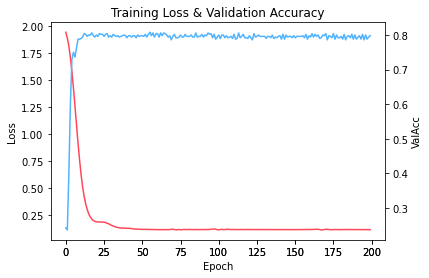

In [16]:
plot_loss_with_acc(loss, val_acc)

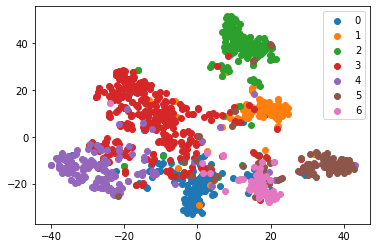

In [19]:
# 绘制测试数据的TSNE降维图
from sklearn.manifold import TSNE
tsne = TSNE()
out = tsne.fit_transform(test_logits)
fig = plt.figure()
for i in range(7):
    indices = test_label == i
    x, y = out[indices].T
    plt.scatter(x, y, label=str(i))
plt.legend()